In [1]:
import os
import pandas as pd
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
import pickle
import random as rand
import time
import sys
from mne.viz import plot_topomap
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt, iirnotch, resample, lombscargle
from scipy import signal
%matplotlib inline

Using TensorFlow backend.


### Preparing the data

In [2]:
# random signal loader, for loading toy data
def random_signal_loader(static_indices, shuffled_non_static_indices, file_path):
    training_instance = False
    
    if(len(shuffled_non_static_indices) == 0):
        shuffled_non_static_indices = list(static_indices)
        rand.shuffle(shuffled_non_static_indices)
    with open(file_path, "rb") as input_file:
        input_file.seek(shuffled_non_static_indices.pop(0))
        training_instance = pickle.load(input_file)
        
    return training_instance, shuffled_non_static_indices

In [3]:
# test and training set size selector, for cropping the data
def set_creator(input_size, data_set):
    size = data_set.shape[0]
    reduce = size % input_size
    if reduce != 0:
        return data_set[:-reduce,:]
    else:
        return data_set

In [4]:
dataset = []

In [5]:
# Load the unsupervised data from folder, make sure the folder name is unsupervised data and in your path
path = os.getcwd() + '\\unsupervised data\\'
print(path)
for file in os.listdir(path + "old\\"):
    if file.endswith(".CSV"):
        data = pd.read_csv(path + "old\\" + file)
        print(data.shape)
        dataset.append(data)
    '''if file.endswith(".edf"):
        print(path+file)
        reader = pyedflib.EdfReader(path+file)
        print(reader)'''

# Get one long data file
data = pd.concat(dataset, ignore_index=True)

C:\Users\tlpel\Documents\Studie\AI1\pAI\code\unsupervised data\
(78000, 36)
(80000, 36)
(79000, 36)
(80000, 36)
(77000, 36)
(191000, 36)
(269000, 36)
(460000, 36)


In [6]:
# check whether everything looks okay, then proceed
print(data.shape)
data.head(10)

(1314000, 36)


,COUNTER,INTERPOLATED,AF3,F7,F3,FC5,T7,P7,O1,O2,...,CQ_T8,CQ_FC6,CQ_F4,CQ_F8,CQ_AF4,CQ_CMS,CQ_DRL,GYROX,GYROY,MARKER
0,53.0,0.0,4622.563990,4075.384516,4276.922972,4031.281953,4685.128091,4216.922974,4779.487063,4410.256302,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1672.0,1679.0,0.0
1,54.0,0.0,4617.435785,4076.410157,4275.384511,4031.281953,4687.692193,4217.435794,4779.487063,4413.333225,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1672.0,1679.0,0.0
2,55.0,0.0,4616.410144,4078.461439,4275.384511,4034.358876,4688.205014,4221.025538,4785.128088,4412.307584,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1670.0,1680.0,0.0
3,56.0,0.0,4617.948605,4082.564003,4274.358870,4037.435799,4688.717834,4220.512717,4784.102447,4412.307584,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1670.0,1682.0,0.0
4,57.0,0.0,4618.974246,4088.717849,4274.358870,4035.897337,4688.205014,4218.974256,4781.538345,4414.871687,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1669.0,1683.0,0.0
5,58.0,0.0,4619.487067,4085.640926,4272.820408,4032.820414,4684.102450,4217.435794,4781.538345,4413.333225,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1669.0,1686.0,0.0
6,59.0,0.0,4611.794759,4077.435798,4265.640921,4028.717850,4679.999886,4212.820410,4772.820396,4404.102456,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1670.0,1685.0,0.0
7,60.0,0.0,4603.076811,4077.948618,4261.025537,4026.666568,4678.974245,4211.281948,4765.128089,4404.615277,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1668.0,1687.0,0.0
8,61.0,0.0,4599.999888,4079.487080,4262.563998,4029.743491,4680.512706,4214.871692,4769.743473,4408.717841,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1670.0,1686.0,0.0
9,62.0,0.0,4601.538349,4074.871695,4263.589639,4032.820414,4683.589629,4216.922974,4771.794755,4402.051174,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1669.0,1686.0,0.0


In [13]:
data.columns
dat = data.loc[:, ' AF3':' AF4'].values
print(dat.shape)

(1314000, 14)


In [8]:
fs = 128.0
f0 = 50.0/6.2
Q = 15.0
w0 = f0/(fs/2)

b, a = iirnotch(w0, Q)
d, c = butter(4, w0, "lowpass")

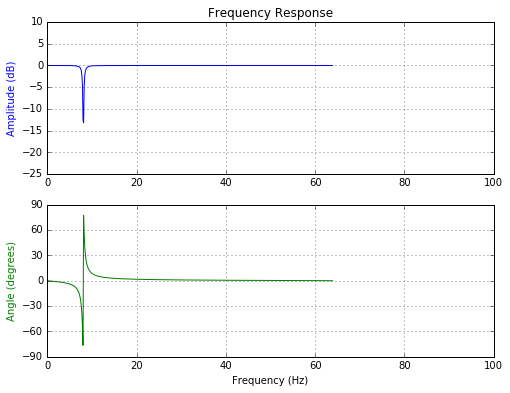

In [50]:
# Frequency response
w, h = signal.freqz(b, a)
# Generate frequency axis
freq = w*fs/(2*np.pi)
# Plot
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([0, 100])
ax[0].set_ylim([-25, 10])
ax[0].grid()
ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Angle (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([0, 100])
ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[1].set_ylim([-90, 90])
ax[1].grid()
plt.show()

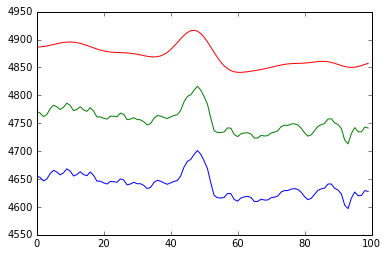

In [51]:
dat = data.loc[:50000, ' AF3'].values
plt.plot(dat[1000:1100])

dat2 = filtfilt(b, a, dat)
dat3 = filtfilt(d, c, dat)

plt.plot(dat2[1000:1100] * 1.025)
plt.plot(dat3[1000:1100] * 1.05)

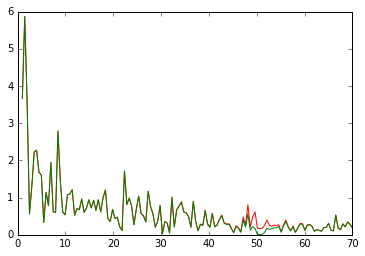

In [52]:
wave2 = dat[:12800] - np.mean(dat[:12800])
normval = wave2.shape[0]
steps = np.linspace(0.0, len(wave2)/(fs), len(wave2))
freqs = np.linspace(1.0, 70.0, 140)
pgram = lombscargle(steps, wave2, freqs)
pgram2 = lombscargle(steps, dat2[:12800] - np.mean(dat2[:12800]), freqs)
pgram3 = lombscargle(steps, dat3[:12800] - np.mean(dat3[:12800]), freqs)
# plt.subplot(3,1,1)
plt.plot(freqs, np.sqrt(4*(pgram/normval)), "r")
# plt.subplot(3,1,2)
plt.plot(freqs, np.sqrt(4*(pgram2/normval)), "g")
# plt.subplot(3,1,3)
# plt.plot(freqs, np.sqrt(4*(pgram3/normval)), "b")

## ICA for noise removal

In [8]:
# Do a 66/34 split of training and test. Play a bit with this to get nice sized training and test sets.
n_train = int(data.shape[0]*0.99) 
n_test = data.shape[0] - n_train

x_train = data.loc[:n_train-1, ' AF3':' AF4'].values
x_test = data.loc[n_train:, ' AF3':' AF4'].values

x_train.shape, x_test.shape, type(x_train), n_train, n_test

shift = min(np.amin(x_train), np.amin(x_test))
normalize = max(np.amax(x_train), np.amax(x_test)) - shift

x_train = (x_train.astype('float32') - shift) / normalize
x_test = (x_test.astype('float32') - shift) / normalize

In [9]:
ica = FastICA(n_components = 14, max_iter=10000, whiten=True)
S = ica.fit_transform(x_train)  # Reconstruct signals
A = ica.mixing_

[ 1  3  9  6  1  8  1  0  6 13 11  5  5  1]
[[  2.29722243e-01  -8.79131508e-01  -2.58948030e-01  -3.80442068e-01
    5.12002229e-02  -1.64718710e-02   1.22831304e+00   3.93027936e+00
   -3.62138061e-01   6.51941045e-01  -8.05209452e+00   3.39346582e-01
    1.58590465e-01  -6.05506084e-02]
 [  5.87636892e-01  -1.44581243e-01   9.53793813e-01  -5.49786528e+00
    2.04305904e+01   1.43136966e-01   2.34131823e+00   5.61460877e-01
   -8.99348691e-01   7.34381392e-01  -8.17300097e+00  -9.00648041e-02
   -3.65091515e-01   1.68682286e-01]
 [  3.46291941e-01  -5.45255850e-01  -4.22987752e-01  -2.50943813e-01
   -1.94916501e-01   9.36368744e-02  -3.54873763e+00   1.56415773e-01
   -5.81466903e-01   1.71931689e-01  -8.33041113e+00   2.91265408e-01
    7.21528316e-02  -3.36231084e-02]
 [  8.85082790e-02   4.89727115e+00  -7.42495357e-02  -4.99911416e-01
   -1.22862037e-01   1.06517940e-01   8.59237639e-01   1.05105897e+00
   -3.09731045e-01   1.51178356e-01  -7.86206465e+00   3.12546933e-04
   -2

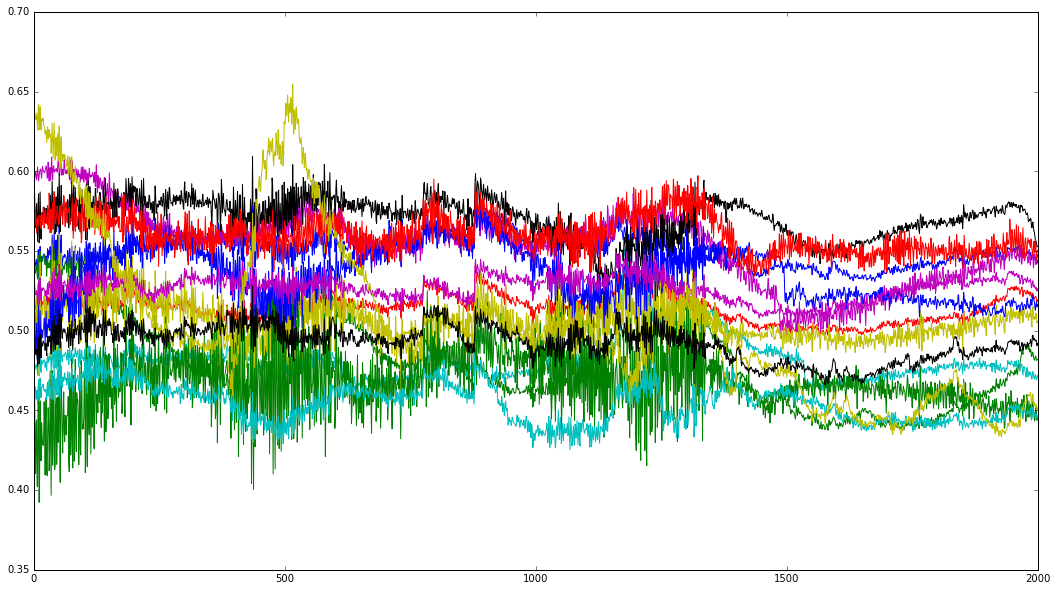

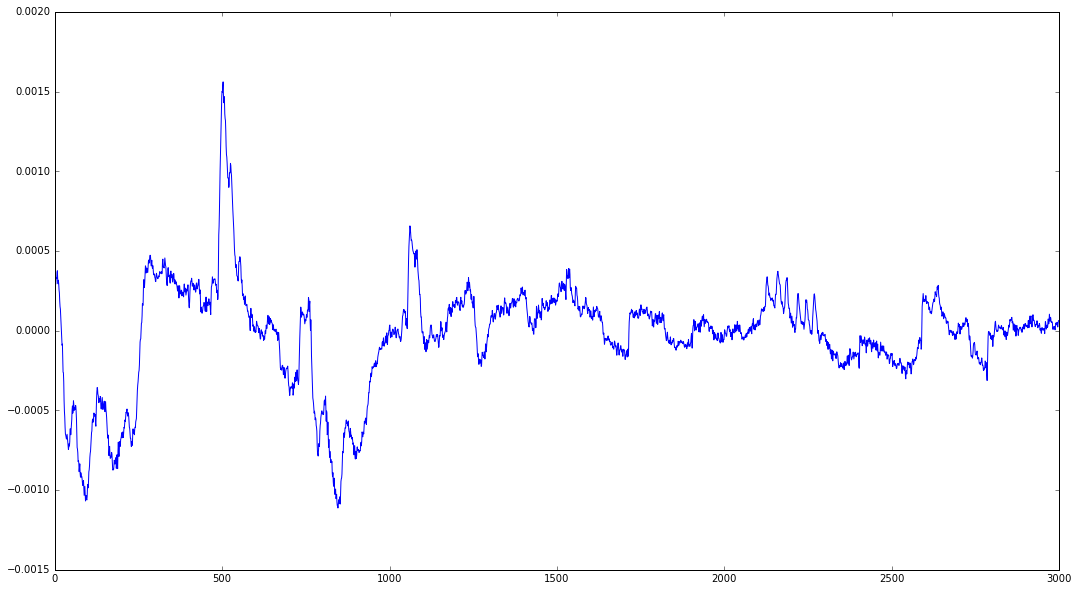

In [10]:
plt.figure(figsize=[18,10])
# plt.plot(StandardScaler().fit_transform(x_train[:50]))
plt.plot(x_train[128000:130000]) #4
plt.figure(figsize=[18,10])
plt.plot(S[2000:5000,4]) #9
print(np.argmax(A,0))
print(A)

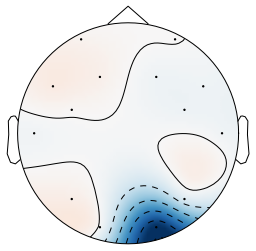

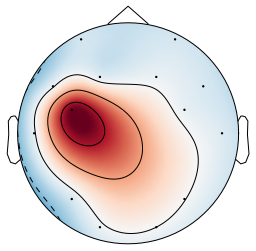

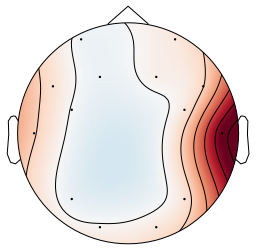

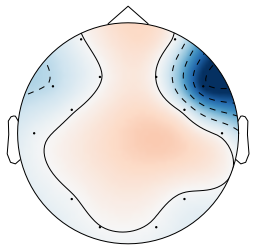

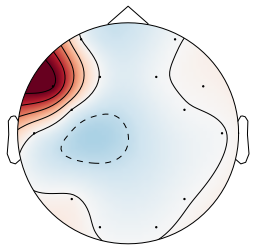

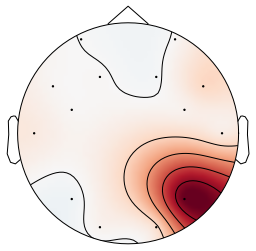

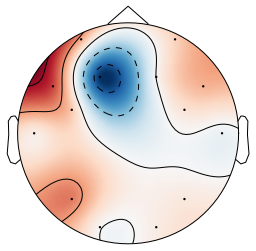

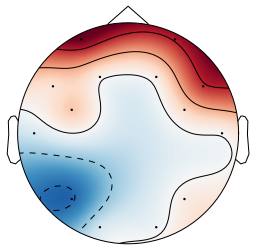

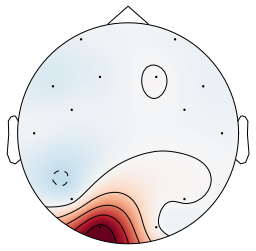

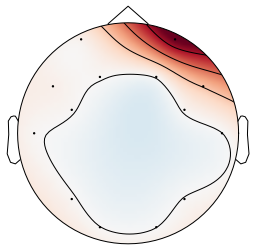

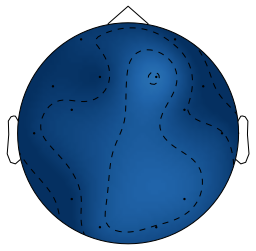

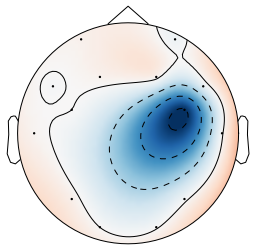

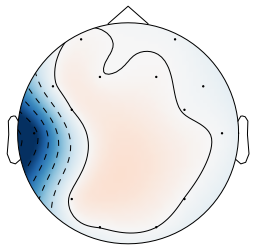

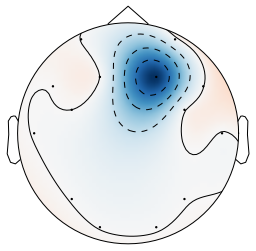

In [11]:
loc = np.array([[-0.5,1.0],[-0.8,0.5],[-0.3,0.6],[-0.6,0.25],[-1.0,0.0],[-0.6,-0.7],[-0.3,-1.0],[0.3,-1.0],[0.6,-0.7],[1.0,0.0],[0.6,0.25],[0.3,0.6],[0.8,0.5],[0.5,1.0]])
for i in range(14):
    plot_topomap(A[:,i], loc)
# for i in range(2000):
#     plot_topomap(np.mean(x_train[i*1:(i+1)*1,:].T,axis=1), loc, vmax=1)

In [97]:
assert np.allclose(x_train, np.dot(S, A.T) + ica.mean_)

AssertionError: 